In [1]:

import torch
import numpy as np
import pandas as pd
from tqdm import tqdm

import transformers
from sentence_transformers import SentenceTransformer

#- Plotting
import matplotlib.pyplot as plt
import seaborn as sns

import nomic
#- Data
from nomic import AtlasDataset

#- Processing
from fuzzywuzzy import fuzz
from unidecode import unidecode
import re
import datetime
import gc

nomic.login("nk-2LSEn5FB5h04Dn0pFLuZ9jDw7ZaMbPpYPV88wbKKASc")

import json
import os
import pickle


dataset = AtlasDataset('hivemind/tweets-from-members-of-us-congress-from-all-time-updated-2024-09-17-1')
bill_meta = pickle.load(open('bill_meta.p', 'rb'))

df = dataset.maps[0].data.df
df.head()

/cis/home/tchen94/anaconda3/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
2024-11-06 12:28:23.343 | INFO     | nomic.dataset:__init__:768 - Loading existing dataset `hivemind/tweets-from-members-of-us-congress-from-all-time-updated-2024-09-17-1`.
2024-11-06 12:28:24.423 | WARNING  | nomic.data_operations:df:923 - Converting to pandas dataframe. This may materialize a large amount of data into memory.
2024-11-06 12:28:24.425 | INFO     | nomic.data_operations:_download_data:902 - Downloading data
100%|██████████| 129/129 [00:00<00:00, 148.63it/s]
2024-11-06 12:28:30.536 | INFO     | nomic.data_operations:_load_data:872 - Loading data
100%|██████████| 129/129 [00:01<00:00, 71.69it/s] 


,tweetId,postedAt,name,state,party,twitter_lower,chamber,years,source,id,text
0,1065633444502224896,2018-11-22 15:49:46.338,Ken Buck R-CO,CO,R,repkenbuck,House,2017_2018,PolitWoops,1203633,Happy #Thanksgiving! I hope everyone has a cha...
1,1479108462504136704,2022-01-06 15:11:52.624,Kat Cammack R-FL,FL,R,repkatcammack,House,2021_2022,PolitWoops,2857207,"RT @MorningsMaria: .@RepKatCammack: ""The Democ..."
2,85108215381102592,2011-06-26 22:12:34.438,Dennis Ross R-FL,FL,R,repdennisross,House,2011_2012,PolitWoops,35353,@CEP_Observer will have to check that out.
3,925691081026621440,2017-11-01 11:48:46.882,Richard Hudson R-NC,NC,R,reprichhudson,House,2017_2018,PolitWoops,954870,RT @BGClubCab: Thanks to @CharlotteWBB for hel...
4,1435963943533568000,2021-09-09 13:50:57.715,Chip Roy R-TX,TX,R,repchiproy,House,2021_2022,PolitWoops,2324693,RT @chiproytx: No. https://t.co/STZW0DdDz1


In [2]:
def capitalize_first_letters(name, delimiter=' '):
    recon=''
    chunks = name.split(delimiter)
    
    for chunk in chunks:
        recon += chunk[0].upper() + chunk[1:] + ' '
        
    return recon.strip()

def get_tweet_start(text, n_characters=30):
    chunks = text.split(' ')

    text_ = chunks[0]
    len_text = len(text_)

    c=1
    while len_text < n_characters and c < len(chunks)-1:
        text_ += ' ' + chunks[c]
        len_text = len(text_)
        c+=1

    return text_, len(chunks) - c

def remove_quotes(tweet, quote_list = ['"', "'", b'\xe2\x80\x9c'.decode()]):
    removed_first_quote = False
    while not removed_first_quote:
        if tweet in quote_list:
            tweet = tweet[1:]
        else:
            removed_first_quote=True

    removed_last_quote = False
    while not removed_first_quote:
        if tweet[-1] in quote_list:
            tweet = tweet[:-1]
        else:
            removed_last_quote=True
            
    if tweet[0] in quote_list:
        tweet = tweet[1:]
    if tweet[-1] in quote_list:
        tweet = tweet[:-1]
        
    return tweet.strip()

In [3]:
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16},
    device_map="cuda:0",
)

embedding_model = SentenceTransformer("nomic-ai/nomic-embed-text-v1.5", trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

<All keys matched successfully>


In [4]:
#- Should be able to re-factor so that we are not keeping n_bills copies of embeddings / text
congress_name_list= list(df['name'].unique())   
n_congresspersons = len(congress_name_list)

name_to_standardized_name = {}

for name in congress_name_list:
    chunks = name.lower().split(' ')[:2]
    if ',' in chunks[0]:
        standardized_name = chunks[1] + '_' + chunks[0][:-1]
    else:
        standardized_name = chunks[0] + '_' + chunks[1]

    name_to_standardized_name[name] = unidecode(standardized_name)
standardized_name_list = list(name_to_standardized_name.values())
    
standardize_vote = {
    'Yea': 'yea', 
    'Aye': 'yea', 
    'Nay': 'nay', 
    'No': 'nay', 
    'Not Voting': 'not voting',
    'Present': 'not voting'
    }
    
cp_metadata_by_bill = {}
text_dict = {}
embd_dict = {}
for bill in tqdm(bill_meta):
    cp_metadata_by_bill[bill] = {}
    
    if bill_meta[bill]['house_vote_id'] == '':
        HOUSE = False
        congress_name_list_house = []
    else:
        HOUSE = True
        
    if bill_meta[bill]['senate_vote_id'] == '':
        SENATE = False
        congress_name_list_senate = []
        
    else:
        SENATE = True
    
    
    if HOUSE:
        year, month, day = bill_meta[bill]['house_vote_date'].split('-')
        house_t = pd.Timestamp(year=int(year), month=int(month), day=int(day))
        
        house_vote_id = bill_meta[bill]['house_vote_id']
        
        df_house = pd.read_csv(f'/cis/home/tchen94/tianyi/congressional-twin/experiments/tianyi/Data/{house_vote_id}.csv', header=0)
        congress_name_list_house = df_house['matched-name'].unique()
        congress_name_list_house = [name for name in congress_name_list_house if pd.notnull(name)][:-1]
        
        
    if SENATE:
        year, month, day = bill_meta[bill]['senate_vote_date'].split('-')
        senate_t =  pd.Timestamp(year=int(year), month=int(month), day=int(day))
        
        senate_vote_id = bill_meta[bill]['senate_vote_id']
    
        df_senate = pd.read_csv(f'/cis/home/tchen94/tianyi/congressional-twin/experiments/tianyi/Data/{senate_vote_id}.csv', header=0)
        congress_name_list_senate = df_senate['matched-name'].unique()
        congress_name_list_senate = [name for name in congress_name_list_senate if pd.notnull(name)][:-1]

    t_dict = {'house': house_t, 'senate': senate_t}
    
    #- Add all congress persons in Atlas dataframe to name_to_standardized_name
    for name in congress_name_list:
        party=df[df['name'] == name]['party'].values[0].lower()
        
        if name in congress_name_list_house:
            vote = standardize_vote[df_house[df_house['matched-name'] == name]['vote'].values[0]]
            chamber='house'
        elif name in congress_name_list_senate:
            vote = standardize_vote[df_senate[df_senate['matched-name'] == name]['vote'].values[0]]
            chamber='senate'
        else:
            vote='n/a'
            chamber=df[df['name'] == name]['chamber'].values[0].lower()
        
        standardized_name = name_to_standardized_name[name]
                    
        if standardized_name not in cp_metadata_by_bill[bill]:
            cp_metadata_by_bill[bill][standardized_name] = {'party': party, 'vote': vote, 'chamber': chamber}
        elif cp_metadata_by_bill[bill][standardized_name]['vote'] == 'n/a':
            cp_metadata_by_bill[bill][standardized_name] = {'party': party, 'vote': vote, 'chamber': chamber}

100%|██████████| 13/13 [02:49<00:00, 13.03s/it]


In [5]:
with open('cmds_dict_inference.p', 'rb') as file:
    cmds_dict = pickle.load(file)

In [ ]:
#list(cmds_dict[bill]['retrieved'].keys())==list(cmds_dict[bill]['generated'].keys())

True

In [43]:
bi_cameral_bills = []

for bill in bill_meta:
    if bill_meta[bill]['senate_vote_id'] != '':
        bi_cameral_bills.append(bill)
        print(bill, bill_meta[bill]['senate_vote_id'])

117-HR-1319 117-2021_s110
117-HR-4346 117-2022_s271
118-HR-7888 118-2024_s150
118-HR-3746 118-2023_s146


In [7]:
np.random.seed(1)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score

score=accuracy_score

def get_indices_by_class(y):
    unique = np.unique(y)
            
    indices_by_class ={}
    for c in unique:
        indices_by_class[c] = np.where(y == c)[0]
        
    return indices_by_class

def get_stratified_folds(y, n_folds):
    indices_by_class = get_indices_by_class(y)
    folds = {i: {'train': [], 'test': []} for i in range(n_folds)}
        
    for c, indices in indices_by_class.items():
        test_per_fold = int(len(indices) *  (1 / n_folds))
        
        for i in range(n_folds):
            folds[i]['test']+= list(indices[i*test_per_fold: (i+1)*test_per_fold])
            
        
    for i in range(n_folds):
        folds[i]['train'] = np.array([j for j in range(len(y)) if j not in folds[i]['test']])
        folds[i]['test'] = np.array(folds[i]['test'])
        
    return folds

def get_stratified_sample(y, p):
    indices_by_class = get_indices_by_class(y)
    
    inds = []
    for c, indices in indices_by_class.items():
        temp = np.random.choice(indices, size=int(p * len(indices)), replace=False)
        inds += list(temp)
    
    return inds


def get_party_line(y, party_list): 
    party_types = np.unique(party_list)
    
    party_to_vote_dict = {}
    for party_type in party_types:
        unique, counts = np.unique(y[party_list == party_type], return_counts=True)
        party_to_vote_dict[party_type] = unique[np.argmax(counts)]
        
    return party_to_vote_dict

In [35]:
from graspologic.plot import pairplot, heatmap

party_color_dict = {'d': 'tab:blue', 'r': 'tab:red', 'i': 'tab:green', 'n/a': 'k'}
vote_color_dict = {'nay': 'tab:red', 'yea': 'tab:green', 'not voting': 'tab:olive', 'n/a': 'k'}

party_by_bill = {}
vote_by_bill = {}
chamber_by_bill = {}
name_list_2 = {}

for bill in cmds_dict:
    if bill_meta[bill]['house_vote_id'] == '':
        continue
    
    name_list = list(cmds_dict[bill]['retrieved'].keys())
    cmds_retrieved = np.array(list(cmds_dict[bill]['retrieved'].values()))
    cmds_generated = np.array(list(cmds_dict[bill]['generated'].values()))

    party_by_bill[bill] = np.array([cp_metadata_by_bill[bill][name]['party'] for name in name_list])
    vote_by_bill[bill] = np.array([cp_metadata_by_bill[bill][name]['vote'] for name in name_list])
    name_list_2[bill] = np.array(name_list)
    chamber_by_bill[bill] = np.array([cp_metadata_by_bill[bill][name]['chamber'] for name in name_list]) 
    
    party_list = party_by_bill[bill]

In [34]:
np.array(list([1,2,2,2,3,23,1]))[0:4]

array([1, 2, 2, 2])

In [36]:
## tuning the knn k parameter:
n_folds=20
n_neighbors_list = [1,2,3,4,10,15,20,30,50,10]

best_score_generated = {}
argbest_score_generated = {}
std_best_generated = {}

best_score_retrieved = {}
argbest_score_retrieved = {}
std_best_retrieved = {}

std_results_dict = {}
average_results_dict = {}

for bill in cp_metadata_by_bill:
    if bill_meta[bill]['house_vote_id'] == '' or bill_meta[bill]['senate_vote_id'] =='':
        continue

    average_results_dict[bill] = {}
    std_results_dict[bill] = {}
    
    best_score_generated[bill] = -1
    argbest_score_generated[bill] = -1
    std_best_generated[bill] = -1
    
    
    best_score_retrieved[bill] = -1
    argbest_score_retrieved[bill] = -1
    std_best_retrieved[bill] = -1
    
    vote_list = vote_by_bill[bill]
    party_list = party_by_bill[bill]
    
    voter_inds_house = np.array([i for i, v in enumerate(vote_list) if v in ['yea', 'nay'] and chamber_by_bill[bill][i] == 'house'])
    #voter_inds_senate = np.array([i for i, v in enumerate(vote_list) if v in ['yea', 'nay'] and chamber_by_bill[bill][i] == 'senate'])

    n_voters_house = len(voter_inds_house)
    #n_voters_senate = len(voter_inds_senate)
        
    folds = get_stratified_folds(vote_list[voter_inds_house], n_folds)
    
    results_dict = {k: {'retrieved': [], 'generated': [], 'majority': [], 'party-line': []} for k in n_neighbors_list}
    for k in n_neighbors_list:
        for mc in range(n_folds):
            train_inds = folds[mc]['train']
            test_inds = folds[mc]['test']
            
            for type_, cmds in cmds_dict[bill].items():
                model = KNeighborsClassifier(n_neighbors=k)
                
                cmds = np.array(list(cmds_dict[bill][type_].values()))
                model.fit(cmds[voter_inds_house][train_inds], vote_list[voter_inds_house][train_inds])

                y_pred = model.predict(cmds[voter_inds_house][test_inds])
                results_dict[k][type_].append(score(vote_list[voter_inds_house][test_inds], y_pred))


            if k != n_neighbors_list[-1]:
                continue
                
            #- majority
            unique, return_counts = np.unique(vote_list[voter_inds_house][train_inds], return_counts=True)
            y_pred = len(test_inds) * [unique[np.argmax(return_counts)]]
            results_dict[k]['majority'].append(score(vote_list[voter_inds_house][test_inds], y_pred))


            #- party line vote
            y_pred = [get_party_line(vote_list[voter_inds_house], party_list[voter_inds_house])[p] for p in party_list[voter_inds_house][test_inds]]
            results_dict[k]['party-line'].append(score(vote_list[voter_inds_house][test_inds], y_pred))

        if np.mean(results_dict[k]['generated']) > best_score_generated[bill]:
            best_score_generated[bill] = np.mean(results_dict[k]['generated'])
            argbest_score_generated[bill] = k
            std_best_generated[bill] = np.std(results_dict[k]['generated'])
            
        if np.mean(results_dict[k]['retrieved']) > best_score_retrieved[bill]:
            best_score_retrieved[bill] = np.mean(results_dict[k]['retrieved'])
            argbest_score_retrieved[bill] = k
            std_best_retrieved[bill] = np.std(results_dict[k]['retrieved'])
            
    for type_, results in results_dict[k].items():
        average_results_dict[bill][type_] = np.mean(results)
        std_results_dict[bill][type_] = np.std(results)
        
    average_results_dict[bill]['retrieved'] = best_score_retrieved[bill]
    average_results_dict[bill]['generated'] = best_score_generated[bill]
    
    std_results_dict[bill]['retrieved'] = std_best_retrieved[bill]
    std_results_dict[bill]['generated'] = std_best_generated[bill]
    
    print(average_results_dict[bill])
    print()

{'retrieved': 0.5576923076923077, 'generated': 0.8346153846153846, 'majority': 0.5384615384615384, 'party-line': 0.9961538461538462}

{'retrieved': 0.6125, 'generated': 0.8375, 'majority': 0.5, 'party-line': 0.9958333333333332}

{'retrieved': 0.6923076923076922, 'generated': 0.7807692307692309, 'majority': 0.6923076923076923, 'party-line': 0.6923076923076923}

{'retrieved': 0.75, 'generated': 0.75, 'majority': 0.75, 'party-line': 0.75}



117-HR-1319 0.8346153846153846
117-HR-4346 0.8375
118-HR-7888 0.7807692307692309
118-HR-3746 0.75


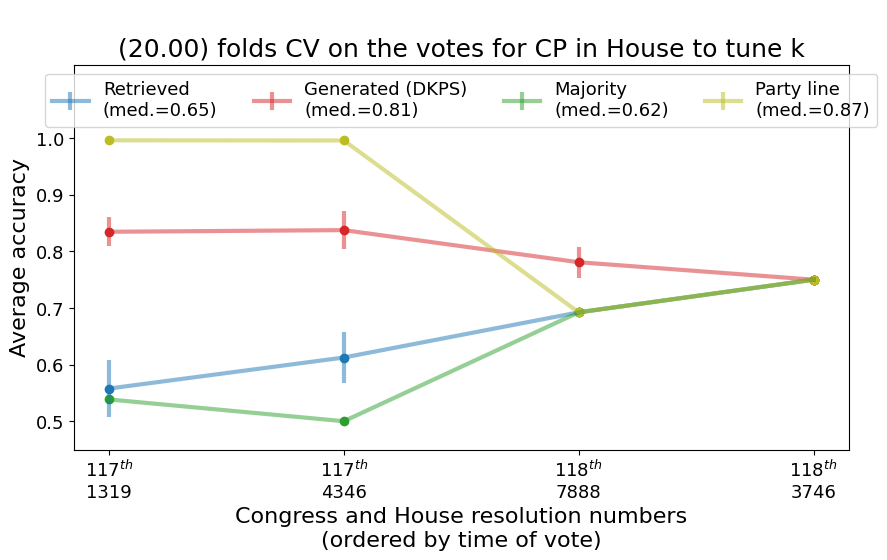

In [18]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
bill_list = list(average_results_dict.keys())
# bill_list.remove('118-HR 1435')

method_list = list(average_results_dict[bill_list[0]].keys())

bill_labels= []
for bill in bill_list:
    if bill == '118-HR 1435':
        bill_labels.append(r'118$^{th}$'+'\n1435')
        continue
    split = bill.split('-')
    bill_labels.append(f'{split[0]}' + r'$^{th}$' + '\n' + split[2])

# markers=['*', '^', 'v']
# bill_to_marker = {bill: markers[i] for i, bill in enumerate(bill_list)}

colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:olive']
method_to_color = {method: colors[i] for i, method in enumerate(method_list)}

legend_dict = {
    'retrieved': 'Retrieved', 
    'generated': 'Generated (DKPS)',
    'majority': 'Majority', 
    'party-line': 'Party line'
}

result_by_method = {method: [] for method in method_list}
std_by_method = {method: [] for method in method_list}
for i, bill in enumerate(bill_list):
    for j, (method, avg) in enumerate(average_results_dict[bill].items()):
        if method == 'generated':
            print(bill, avg)
        ax.scatter(i, avg, color=method_to_color[method])
        result_by_method[method].append(avg)
        std_by_method[method].append(std_results_dict[bill][method])
    
for method in result_by_method:
    median = np.median(result_by_method[method])
    ax.errorbar(range(len(bill_list)), result_by_method[method], yerr=std_by_method[method] / np.sqrt(10), color=method_to_color[method], alpha=0.5, lw=3, 
                label=legend_dict[method]+f'\n(med.={median:1.2f})')
    
ax.set_xticks(range(len(bill_list)), labels=bill_labels)
ax.set_xlabel('Congress and House resolution numbers\n(ordered by time of vote)', fontsize=16)
ax.tick_params(labelsize=13)
ax.set_ylabel('Average accuracy', fontsize=16)
ax.set_title( f'\n({n_folds:1.2f}) folds CV on the votes for CP in House to tune k', fontsize=18)
# ax.set_xlim(-.05, 2.05)
ax.set_ylim(0.45, 1.13)
ax.set_yticks([0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.legend(fontsize=13, loc='upper center', ncols=4)


In [38]:
argbest_score_generated

{'117-HR-1319': 20, '117-HR-4346': 15, '118-HR-7888': 30, '118-HR-3746': 50}

In [42]:
## predict on the senate vote

results_dict_senate = {'retrieved': [], 'generated': [], 'majority': [], 'party-line': []}
senate_flip_score={}

for bill in argbest_score_generated.keys():
    
    senate_flip_score[bill]={}
    ## train on all house votes
    
    vote_list = vote_by_bill[bill]
    party_list = party_by_bill[bill]
    name_list=name_list_2[bill]
    
    voter_inds_house = np.array([i for i, v in enumerate(vote_list) if v in ['yea', 'nay'] and chamber_by_bill[bill][i] == 'house'])
    voter_inds_senate = np.array([i for i, v in enumerate(vote_list) if v in ['yea', 'nay'] and chamber_by_bill[bill][i] == 'senate'])
    
    #- majority
    unique, return_counts = np.unique(vote_list[voter_inds_house], return_counts=True)
    y_pred = len(voter_inds_senate) * [unique[np.argmax(return_counts)]]
    results_dict_senate['majority'].append(score(vote_list[voter_inds_senate], y_pred))


    #- party line vote
    y_pred = [get_party_line(vote_list[voter_inds_house], party_list[voter_inds_house])[p if p != 'i' else 'd'] for p in party_list[voter_inds_senate]]
    results_dict_senate['party-line'].append(score(vote_list[voter_inds_senate], y_pred))

    n_voters_house = len(voter_inds_house)
    
    #- generated 
    k = argbest_score_generated[bill]
    model = KNeighborsClassifier(n_neighbors=k)
                
    cmds = np.array(list(cmds_dict[bill]['generated'].values()))
    model.fit(cmds[voter_inds_house], vote_list[voter_inds_house])

    y_pred = model.predict(cmds[voter_inds_senate])
    y_pred_proba = model.predict_proba(cmds[voter_inds_senate])
    
    flip_score=y_pred_proba[:,0]*y_pred_proba[:,1]*4
    
    #print(name_list[voter_inds_senate],flip_score)
    
    senate_flip_score[bill] = { 'flip_score': flip_score, 
                               'name_list': name_list[voter_inds_senate],
                               'true_votes': vote_list[voter_inds_senate],
                               'party': party_list[voter_inds_senate]} 

    
    results_dict_senate['generated'].append(score(vote_list[voter_inds_senate], y_pred))
    
    #-retrieved
    k = argbest_score_retrieved[bill]
    model = KNeighborsClassifier(n_neighbors=k)
    
    cmds = np.array(list(cmds_dict[bill]['retrieved'].values()))
    model.fit(cmds[voter_inds_house], vote_list[voter_inds_house])
    
    y_pred = model.predict(cmds[voter_inds_senate])
    results_dict_senate['retrieved'].append(score(vote_list[voter_inds_senate], y_pred))
    
        
    print(average_results_dict[bill])    

{'retrieved': 0.5576923076923077, 'generated': 0.8346153846153846, 'majority': 0.5384615384615384, 'party-line': 0.9961538461538462}
{'retrieved': 0.6125, 'generated': 0.8375, 'majority': 0.5, 'party-line': 0.9958333333333332}
{'retrieved': 0.6923076923076922, 'generated': 0.7807692307692309, 'majority': 0.6923076923076923, 'party-line': 0.6923076923076923}
{'retrieved': 0.75, 'generated': 0.75, 'majority': 0.75, 'party-line': 0.75}


In [45]:
bill_meta[bi_cameral_bills[0]]

{'abstract': 'To provide for reconciliation pursuant to title II of S. Con. Res. 5',
 'summary': 'This bill provides additional relief to address the continued impact of COVID-19 (i.e., coronavirus disease 2019) on the economy, public health, state and local governments, individuals, and businesses.',
 'house_vote_date': '2021-02-27',
 'house_vote_id': '117-2021_h49',
 'senate_vote_date': '2021-03-06',
 'senate_vote_id': '117-2021_s110',
 'questions': ['Do you support the additional COVID-19 relief measures proposed in this bill?',
  'Which provisions of the bill do you believe will have the most significant impact?',
  'Are there any aspects of the bill you disagree with or would like to see modified?',
  'How do you think this bill will affect the economy in the short and long term?',
  'Does the bill provide adequate support for public health initiatives against COVID-19?',
  'In what ways will this bill assist state and local governments dealing with the pandemic?',
  'Do you feel 

In [53]:
senate_flip_score[bi_cameral_bills[0]]
top_10_names = [senate_flip_score[bi_cameral_bills[0]]['name_list'][i] for i in np.argsort(senate_flip_score[bi_cameral_bills[0]]['flip_score'])[::-1][:10]]
top_10_names

['joni_ernst',
 'sheldon_whitehouse',
 'john_cornyn',
 'deb_fischer',
 'john_hoeven',
 'angus_king',
 'maggie_hassan',
 'christopher_murphy',
 'todd_young',
 'richard_blumenthal']

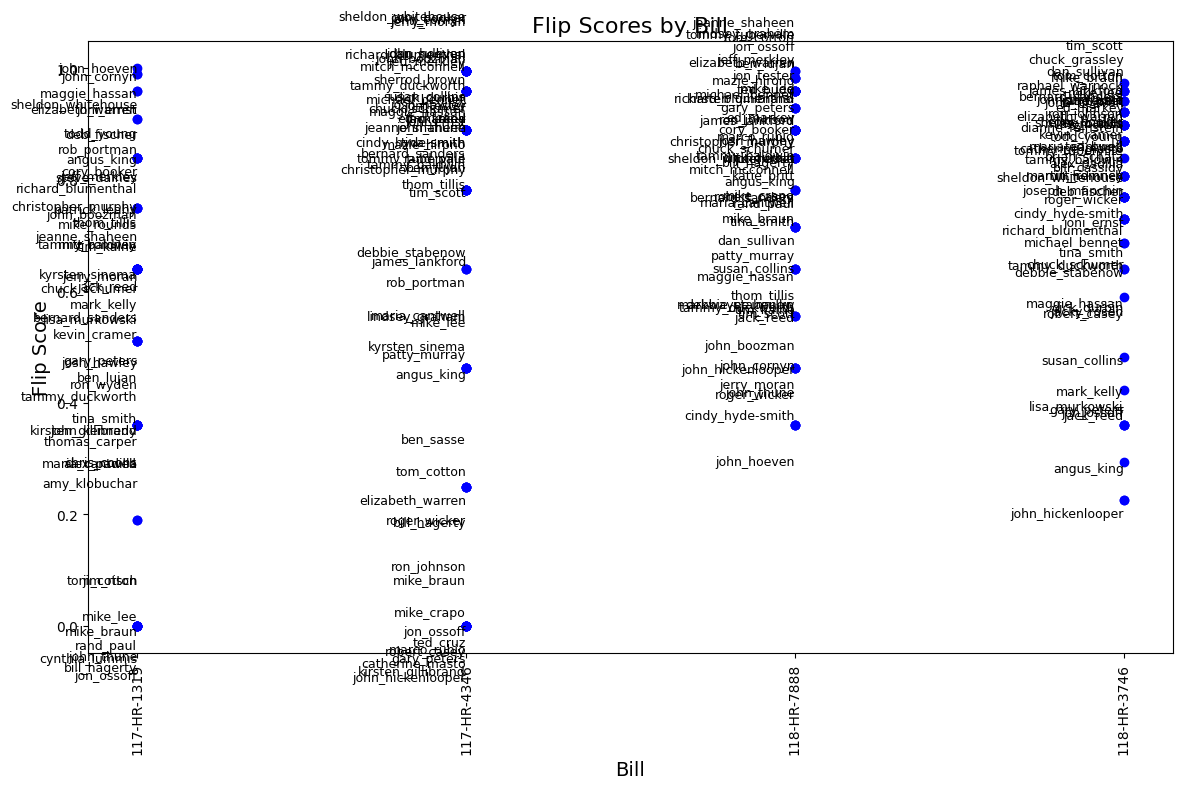

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `senate_flip_score` is defined
fig, ax = plt.subplots(figsize=(12, 8))

# Set the amount of jitter for the labels
jitter_strength = 0.1  # Adjust this as needed for optimal spacing

# Iterate through each bill in senate_flip_score
for bill in senate_flip_score:
    flip_scores = senate_flip_score[bill]['flip_score']
    names = senate_flip_score[bill]['name_list']
    
    # Plot each flip score
    for i, score in enumerate(flip_scores):
        # Scatter each point
        ax.scatter(bill, score, color='blue')
        # Add jitter to the y-coordinate of the label to avoid overlap
        jitter = np.random.uniform(-jitter_strength, jitter_strength)
        ax.text(bill, score + jitter, names[i], fontsize=9, ha='right')

# Set labels and title
ax.set_xlabel('Bill', fontsize=14)
ax.set_ylabel('Flip Score', fontsize=14)
ax.set_title('Flip Scores by Bill', fontsize=16)

# Rotate x-ticks for better readability
plt.xticks(rotation=90)

# Layout adjustments for tight fit
plt.tight_layout()

# Show the plot
plt.show()



In [57]:
senate_flip_score[bill]['party']

array(['d', 'r', 'r', 'r', 'd', 'd', 'r', 'r', 'r', 'd', 'i', 'd', 'r',
       'd', 'r', 'r', 'd', 'd', 'd', 'd', 'i', 'd', 'r', 'd', 'd', 'r',
       'r', 'r', 'd', 'd', 'r', 'd', 'r', 'd', 'd', 'd', 'r', 'd', 'r',
       'd', 'd', 'r', 'd', 'd', 'r', 'r', 'd', 'r', 'd', 'd', 'r', 'r',
       'd', 'r', 'r', 'r', 'r', 'd'], dtype='<U1')

TypeError: can only concatenate str (not "float") to str

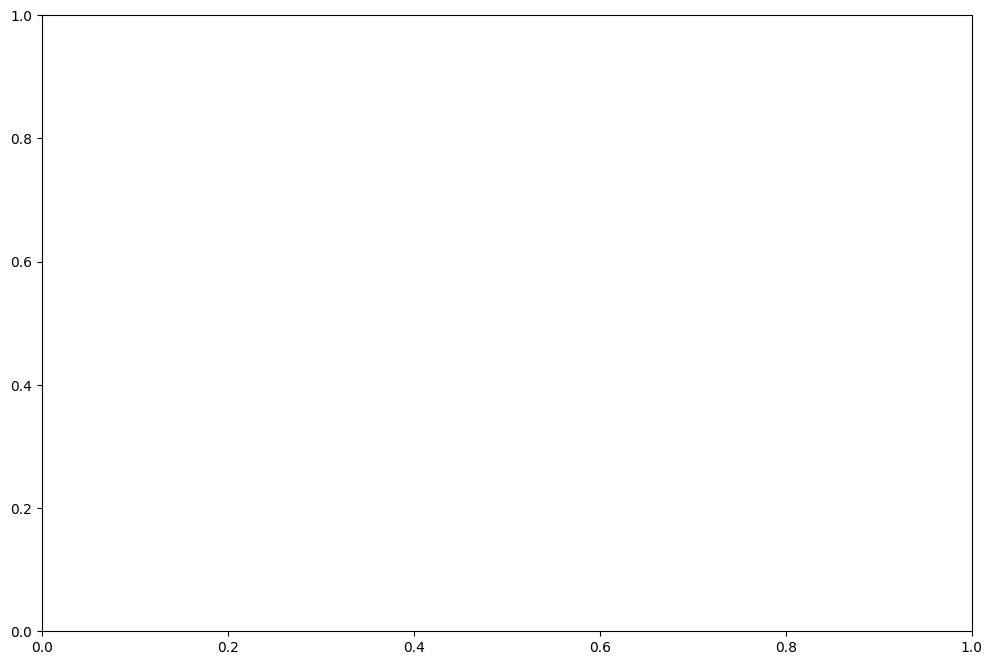

In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `senate_flip_score` is defined and contains 'party' info for coloring
fig, ax = plt.subplots(figsize=(12, 8))

# Set the amount of jitter for both horizontal and vertical directions
jitter_strength = 0.1  # Adjust this for optimal spacing

# Define a color mapping based on party affiliation
party_colors = {'d': 'blue', 'r': 'red', 'i': 'green'}  # Adjust as needed

# Iterate through each bill in senate_flip_score
for bill in senate_flip_score:
    flip_scores = senate_flip_score[bill]['flip_score']
    names = senate_flip_score[bill]['name_list']
    parties = senate_flip_score[bill]['party']
    
    # Plot each flip score
    for i, score in enumerate(flip_scores):
        # Choose color based on party
        color = party_colors.get(parties[i], 'gray')  # Default to gray if party not found
        
        # Generate horizontal and vertical jitter
        x_jitter = np.random.uniform(-jitter_strength, jitter_strength)
        y_jitter = np.random.uniform(-jitter_strength, jitter_strength)
        
        # Scatter each point with its party color, applying jitter
        ax.scatter(bill + x_jitter, score + y_jitter, color=color)
        
        # Jitter and alternate label positions
        if i % 2 == 0:
            # Align some labels to the right
            ax.text(bill + x_jitter, score + y_jitter, names[i], fontsize=9, ha='right')
        else:
            # Align others to the left
            ax.text(bill + x_jitter, score + y_jitter, names[i], fontsize=9, ha='left')

# Set labels and title
ax.set_xlabel('Bill', fontsize=14)
ax.set_ylabel('Flip Score', fontsize=14)
ax.set_title('Flip Scores by Bill', fontsize=16)

# Rotate x-ticks for better readability
plt.xticks(rotation=90)

# Layout adjustments for tight fit
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
import random

# Get all names from senate_flip_score
all_names = []
for bill in senate_flip_score:
    all_names.extend(senate_flip_score[bill]['name_list'])

# Randomly pick 5 names
random_names = random.sample(all_names, 5)
print(random_names)

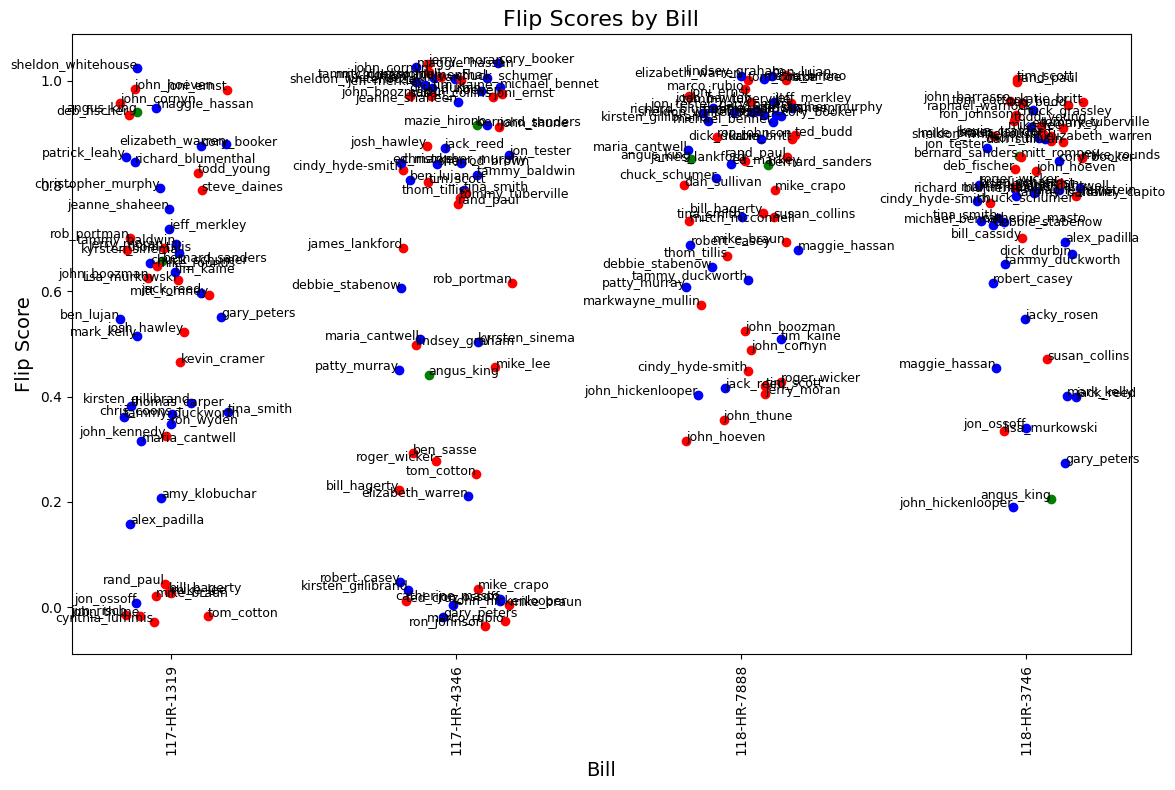

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `senate_flip_score` is defined and contains 'party' info for coloring
fig, ax = plt.subplots(figsize=(12, 8))

# Set the amount of jitter for both horizontal and vertical directions
jitter_strength_v = 0.05 # Adjust this for optimal spacing
jitter_strength_h = 1

# Define a color mapping based on party affiliation
party_colors = {'d': 'blue', 'r': 'red', 'i': 'green'}  # Adjust as needed

# Create a mapping from bill names to numeric positions
bills = list(senate_flip_score.keys())
bill_positions = np.arange(len(bills))*5

# Set custom x-tick labels to match the bill names
ax.set_xticks(bill_positions)
ax.set_xticklabels(bills, rotation=90)

# Iterate through each bill and corresponding position in senate_flip_score
for pos, bill in zip(bill_positions, bills):
    flip_scores = senate_flip_score[bill]['flip_score']
    names = senate_flip_score[bill]['name_list']
    parties = senate_flip_score[bill]['party']
    
    # Plot each flip score
    for i, score in enumerate(flip_scores):
        # Choose color based on party
        color = party_colors.get(parties[i], 'gray')  # Default to gray if party not found
        
        # Generate horizontal and vertical jitter
        x_jitter = np.random.uniform(-jitter_strength_h, jitter_strength_h)
        y_jitter = np.random.uniform(-jitter_strength_v, jitter_strength_v)
        
        # Scatter each point with its party color, applying jitter
        ax.scatter(pos + x_jitter, score + y_jitter, color=color)
        
        # Jitter and alternate label positions
        if i % 2 == 0:
            # Align some labels to the right
            ax.text(pos + x_jitter, score + y_jitter, names[i], fontsize=9, ha='right')
        else:
            # Align others to the left
            ax.text(pos + x_jitter, score + y_jitter, names[i], fontsize=9, ha='left')

# Set labels and title
ax.set_xlabel('Bill', fontsize=14)
ax.set_ylabel('Flip Score', fontsize=14)
ax.set_title('Flip Scores by Bill', fontsize=16)

# Layout adjustments for tight fit
plt.tight_layout()

# Show the plot
plt.show()

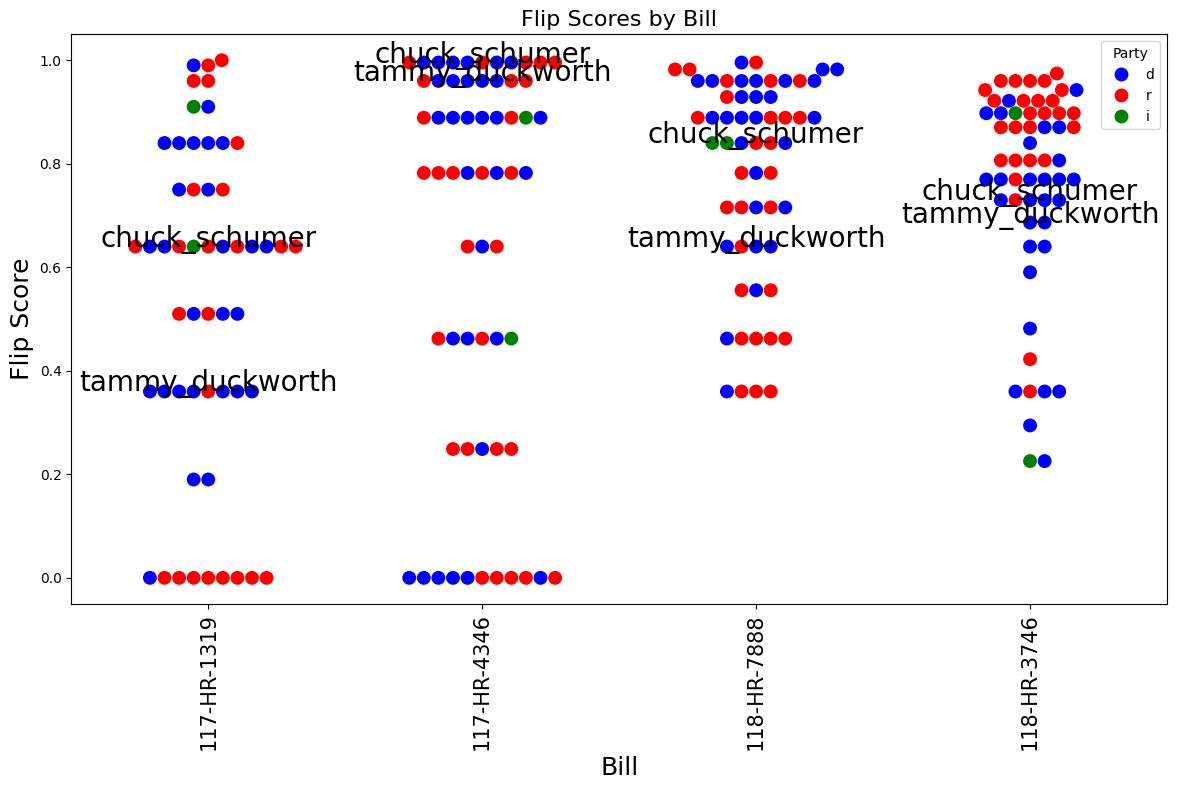

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Flatten the data into a DataFrame for Seaborn
data = []
for bill in senate_flip_score:
    flip_scores = senate_flip_score[bill]['flip_score']
    names = senate_flip_score[bill]['name_list']
    parties = senate_flip_score[bill]['party']
    
    for i, score in enumerate(flip_scores):
        data.append({
            'Bill': bill,
            'Flip Score': score,
            'Name': names[i],
            'Party': parties[i]
        })

# Convert list of dictionaries to DataFrame
df = pd.DataFrame(data)

# Find names that appear in all 4 bills
bills = df['Bill'].unique()
names_in_all_bills = df.groupby('Name').filter(lambda x: set(x['Bill']) == set(bills))['Name'].unique()

# Select the first 5 names that appear in all 4 bills for labeling
label_names = names_in_all_bills[:2]  # Adjust if you need more or fewer labels

# Define a color palette based on party affiliation
party_colors = {'d': 'blue', 'r': 'red', 'i': 'green'}

# Plot with Seaborn swarmplot without horizontal separation (dodge)
plt.figure(figsize=(12, 8))
sns.swarmplot(data=df, x='Bill', y='Flip Score', hue='Party', palette=party_colors,s=10)

# Label the selected points that appear in all 4 bills
for name in label_names:
    points = df[df['Name'] == name]
    for _, point in points.iterrows():
        plt.text(
            x=point['Bill'],
            y=point['Flip Score'],
            s=name,
            fontsize=20,
            ha='center'
        )

# Customize plot
plt.xlabel('Bill', fontsize=18)
plt.ylabel('Flip Score', fontsize=18)
plt.title('Flip Scores by Bill', fontsize=16)
plt.xticks(rotation=90,fontsize=15)
plt.legend(title='Party')

# Display plot
plt.tight_layout()
plt.show()